# YouTube trending videos

In [1]:
from numpy import nan
%matplotlib inline
import random
import xgboost as xgb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import recall_score, f1_score, precision_score, plot_roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from helpers.files import load_csv

plt.rcParams["figure.facecolor"] = "#a9a9a9"
random.seed(0)
np.random.seed(0)


def print_stats(clf, x_train, y_train, x_test, y_test):
    y_train_pred = clf.predict(x_train)
    print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
    print(f"Train precision: {precision_score(y_train, y_train_pred)}")
    print(f"Train recall: {recall_score(y_train, y_train_pred)}")
    print(f"Train F1: {f1_score(y_train, y_train_pred)}\n")
    ax = plt.gca()
    plot_roc_curve(clf, x_train, y_train, name="Train", ax=ax)

    y_test_pred = clf.predict(x_test)
    print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")
    print(f"Test precision: {precision_score(y_test, y_test_pred)}")
    print(f"Test recall: {recall_score(y_test, y_test_pred)}")
    print(f"Test F1: {f1_score(y_test, y_test_pred)}\n")
    plot_roc_curve(clf, x_test, y_test, name="Test", ax=ax)
    plt.show()

# X, y = shap.datasets.boston()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
# # Random Forest
# rf = sklearn.ensemble.RandomForestRegressor()
# rf.fit(X_train, y_train)
#
# # K Nearest Neighbor
# knn = sklearn.neighbors.KNeighborsRegressor()
# knn.fit(X_train, y_train)
#
# # Tree on Random Forest
# explainerRF = shap.TreeExplainer(rf)
# shap_values_RF_test = explainerRF.shap_values(X_test)
# shap_values_RF_train = explainerRF.shap_values(X_train)
#
# # Random Forest
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)
#
# categorical_features = np.argwhere(np.array([len(set(X_train.values[:, x]))
#                                              for x in range(X_train.values.shape[1])]) <= 10).flatten()
#
# # LIME has one explainer for all models
# explainer = lime.lime_tabular.LimeTabularExplainer(
#     X_train.values,
#     feature_names=X_train.columns.values.tolist(),
#     class_names=['price'],
#     categorical_features=categorical_features,
#     verbose=True, mode='regression'
# )
#
# j = 0
# # initialize js for SHAP
# shap.initjs()
#
# exp = explainer.explain_instance(X_test.values[j], rf.predict, num_features=5)
# exp.show_in_notebook(show_table=True)
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], X_test.iloc[[j]])

### Wczytanie danych

In [2]:
load_filtered = True
if load_filtered:
    videos = load_csv("ped6_filtered_data")[0]
else:
    videos = load_csv("ped6_data")[0]

videos = videos.sample(frac=1).reset_index(drop=True)
videos.head(5)
print(len(videos))

12769


### Przygotowanie danych

Train: (10215, 74)
Test: (2554, 74)


,title_len,publish_time_day_of_week,gray_mean_score,color_mean_score,edges_score,entropy_score,title_tfidf_10,title_tfidf_2017,title_tfidf_best,title_tfidf_blackpink,...,tags_tfidf_interview,tags_tfidf_late,tags_tfidf_live,tags_tfidf_makeup,tags_tfidf_music,tags_tfidf_new,tags_tfidf_news,tags_tfidf_review,tags_tfidf_show,tags_tfidf_sport
0,0.536082,0.833333,0.243988,0.555517,0.417947,0.024327,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.432355
1,0.721649,0.166667,0.545909,0.708511,0.480639,0.086253,0.0,0.0,0.0,0.0,...,0.949016,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000
2,0.453608,0.666667,0.319708,0.584645,0.650277,0.032637,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.754576,0.000000
3,0.257732,0.833333,0.466823,0.498824,0.313153,0.047744,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000
4,0.422680,0.666667,0.693762,0.422152,0.463737,0.054544,0.0,0.0,0.0,0.0,...,0.000000,0.540177,0.0,0.0,0.0,0.0,0.43869,0.0,0.421712,0.000000


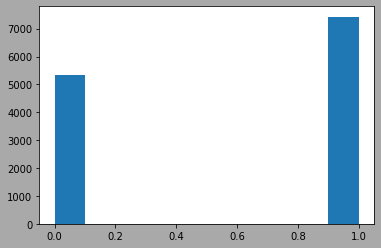

In [3]:
y = videos["trending"]
plt.hist(y)
x = videos.loc[:, videos.columns != "trending"]

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

x_train_stats = x_train.mean()

x_train = x_train.fillna(x_train_stats)
x_test = x_test.fillna(x_train_stats)

scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

print(f"Train: {x_train.shape}")
print(f"Test: {x_test.shape}")
x_train.head(5)

### Wybór miar oceny klasyfikatorów

Accuracy
TODO wyjaśnij wybór.

### Wybór pierwszego klasyfikatora

RandomForest
TODO uzasadnij wybór.

In [4]:
param_grid = {
    "reduce_dim__k": [5, 10, 20, 25, 30],  # range(1, 50, 5),
    "classifier__max_depth": [4, 8, 10],
    "classifier__min_samples_leaf": [1, 2],  # 2, 4],
    "classifier__n_estimators": [10, 50, 100, 200]

}

pipeline = Pipeline([
    ("reduce_dim", SelectKBest(chi2)),
    ("classifier", RandomForestClassifier())
])

grid_search = GridSearchCV(pipeline, n_jobs=8, param_grid=param_grid, cv=10, verbose=1, scoring="f1")
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
{'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200, 'reduce_dim__k': 30}



### Uczenie pierwszego klasyfikatora

In [5]:
k = grid_search.best_params_["reduce_dim__k"]
max_depth = grid_search.best_params_["classifier__max_depth"]
min_samples_leaf = grid_search.best_params_["classifier__min_samples_leaf"]
n_estimators = grid_search.best_params_["classifier__n_estimators"]
# Tree on Random Forest
select = SelectKBest(chi2, k=k)

x_train_selected = select.fit_transform(x_train, y_train)
x_test_selected = select.transform(x_test)

mask = select.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf
)
rf.fit(x_train_selected, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200)

### Testowanie pierwszego klasyfikatora

Train accuracy: 0.7161037689672051
Train precision: 0.6840067747398983
Train recall: 0.9515314708852238
Train F1: 0.7958896396396397

Test accuracy: 0.6883320281910729
Test precision: 0.6642857142857143
Test recall: 0.9387617765814267
Test F1: 0.7780256553262689



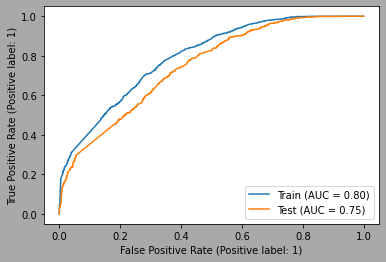

In [6]:
print_stats(rf, x_train_selected, y_train, x_test_selected, y_test)
rf_pred = lambda x: rf.predict_proba(x).astype(float)


### Interpretacja predykcji pierwszego klasyfikatora

Intercept -0.5620802451329241
Prediction_local [0.60277256]
Right: 0.5719616928690019


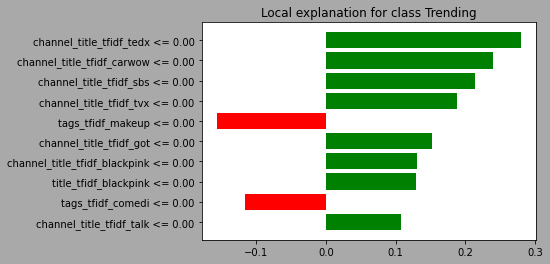

In [7]:
explainerRF = shap.TreeExplainer(rf)

shap_values_RF_test = explainerRF.shap_values(x_test_selected, approximate=True)
shap_values_RF_train = explainerRF.shap_values(x_train_selected, approximate=True)
# Random Forest
#TODO check index
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test[1], columns=x_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train[1], columns=x_train.columns.values)

# LIME has one explainer for all models
explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train_selected.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True,
)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], rf_pred)
exp.save_to_file("lime.html")
# exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
plt.show(fig)

In [8]:
j = 123
x_test_selected.loc[[j]]

,title_tfidf_blackpink,title_tfidf_first,title_tfidf_highlight,channel_title_tfidf_blackpink,channel_title_tfidf_carwow,channel_title_tfidf_got,channel_title_tfidf_late,channel_title_tfidf_news,channel_title_tfidf_nfl,channel_title_tfidf_night,...,tags_tfidf_anim,tags_tfidf_comedi,tags_tfidf_food,tags_tfidf_funni,tags_tfidf_late,tags_tfidf_makeup,tags_tfidf_new,tags_tfidf_news,tags_tfidf_show,tags_tfidf_sport
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.892188,0.0,0.0,0.277525,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
print(y_test.to_numpy()[j])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP

shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


In [10]:
j = 2000
x_test_selected.loc[[j]]

,title_tfidf_blackpink,title_tfidf_first,title_tfidf_highlight,channel_title_tfidf_blackpink,channel_title_tfidf_carwow,channel_title_tfidf_got,channel_title_tfidf_late,channel_title_tfidf_news,channel_title_tfidf_nfl,channel_title_tfidf_night,...,tags_tfidf_anim,tags_tfidf_comedi,tags_tfidf_food,tags_tfidf_funni,tags_tfidf_late,tags_tfidf_makeup,tags_tfidf_new,tags_tfidf_news,tags_tfidf_show,tags_tfidf_sport
2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
print(y_test.to_numpy()[j])
# shap.force_plot(explainerRF.expected_value, shap_values_RF_test[j], x_test.iloc[[j]])
shap_val = explainerRF.shap_values(x_test_selected.loc[[j]], approximate=True)
print(np.array(shap_val).shape)
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerRF.expected_value[1], shap_val[1], x_test_selected.loc[[j]])


0
(2, 1, 30)


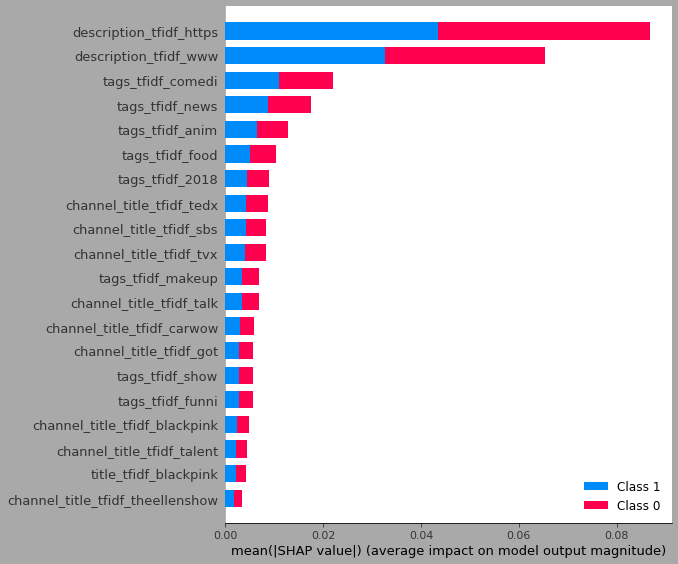

In [12]:
shap.summary_plot(shap_val, x_test_selected.loc[[j]])

### Interpretacja treningowych danych

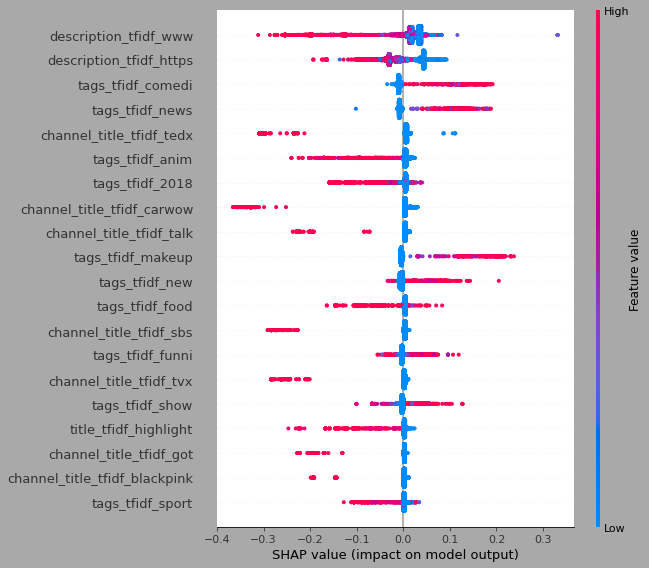

In [13]:
shap.summary_plot(shap_values_RF_train[1], x_train_selected)

### Interpretacja testowych danych

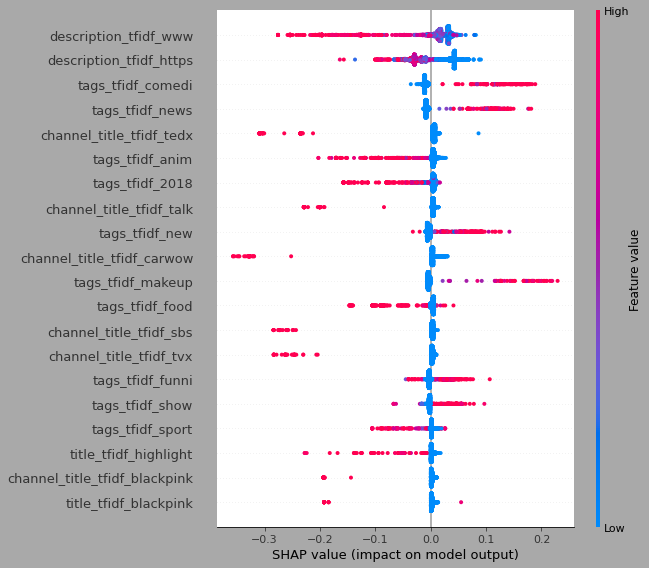

In [14]:
shap.summary_plot(shap_values_RF_test[1], x_test_selected)

# TODO pomyśl o filtrowaniu danych
# TODO pomyśl o odfiltrowaniu innych języków

### Wybór drugiego klasyfikatora

Jako drugi klasyfikator został wybrany XGBoost, ponieważ jest znany z tego że osiąga dobre wyniki (nawet na niezbalansowanych danych) jak i bardzo dobrze wyjaśnialny, poprzez to że w swojej mechanice ma zawarte ważności cech oraz prez zastosowanie boostingu oraz regularyzacji wewnątrz modelu.

### Testowanie klasyfikatora

In [15]:
xgbclf_base = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, verbose=0)

print(xgbclf_base.fit(x_train, y_train))

y_pred = xgbclf_base.predict(x_test)
print(classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

[13:04:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:04:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_chil

### Uczenie drugiego klasyfikatora

**Selekcja cech**

Selekcja cech została przeporwadzona poprzez analizę upadku trafności wraz z ograniczaniem liczby cech modelu

In [16]:
from sklearn.feature_selection import SelectFromModel

thresholds = sorted(xgbclf_base.feature_importances_)

selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbose=0)
selection_model.fit(x_train, y_train)
print("Base accuracy: %.2f%%" % (accuracy_score(y_test, selection_model.predict(x_test)) * 100))

for thresh in thresholds:
    selection = SelectFromModel(xgbclf_base, threshold=thresh, prefit=True)
    select_x_train = selection.transform(x_train)
    selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbose=0)
    selection_model.fit(select_x_train, y_train)
    select_x_test = selection.transform(x_test)
    y_pred = selection_model.predict(select_x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_x_train.shape[1], accuracy * 100.0))

[13:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Base accuracy: 76.27%
[13:04:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some para

Jak rozsądną wartość ilość cech została ograniczona do 56, ze spadkiem trafności koło 1,5%

### Interpretacja predykcji

In [17]:
thresh = thresholds[-56]
selection = SelectFromModel(xgbclf_base, threshold=thresh, prefit=True)
x_train_selected = selection.transform(x_train)

selection_model = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, verbose=0)
selection_model.fit(x_train_selected, y_train)

x_test_selected = selection.transform(x_test)
y_pred = selection_model.predict(x_test_selected)
accuracy = accuracy_score(y_test, y_pred)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, x_train_selected.shape[1], accuracy * 100.0))

mask = selection.get_support()
new_features = [feature for supported, feature in zip(mask, x.columns.values) if supported]

x_train_selected = pd.DataFrame(x_train_selected, columns=new_features)
x_test_selected = pd.DataFrame(x_test_selected, columns=new_features)

[13:06:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:06:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.005, n=56, Accuracy: 74.63%


**Strojenie parametrów**

Strojenie odbywa się na modelu o mniejszej ilości estymatorów (ze względu na czas obliczeń)

In [18]:
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 2, 5],
    'max_depth': [3, 6, 9, 15]
}
xgbclf_par = xgb.XGBClassifier(n_estimators=10, use_label_encoder=False, nthread=1, verbosity=0)
grid_search = GridSearchCV(xgbclf_par, n_jobs=8, param_grid=params, cv=3, verbose=1)
grid_search.fit(x_train_selected, y_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'gamma': 2, 'max_depth': 15, 'min_child_weight': 1}


In [19]:
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_score_)

[0.71395007 0.71522271 0.71267744 0.7669114  0.76573666 0.7587861
 0.79569261 0.79099364 0.77885463 0.80890847 0.80372002 0.79441997
 0.71395007 0.71404797 0.71287323 0.7671072  0.76720509 0.76064611
 0.79393049 0.79295154 0.78051884 0.80900636 0.80283896 0.79647577
 0.71316691 0.71395007 0.71522271 0.77415565 0.76642193 0.75829662
 0.79295154 0.78795888 0.78257465 0.8042095  0.79676946 0.79676946]
0.8090063631913852


### Uczenie drugiego klasyfikatora

In [20]:
xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0
              )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [21]:
min_child_weight = grid_search.best_params_["min_child_weight"]
max_depth = grid_search.best_params_["max_depth"]
gamma = grid_search.best_params_["gamma"]

xgbclf = xgb.XGBClassifier(n_estimators=1000, use_label_encoder=False, nthread=-1, verbosity=0,
                           objective='binary:logistic',
                           min_child_weight=min_child_weight,
                           max_depth=max_depth,
                           gamma=gamma)

xgbclf.fit(x_train_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

bez selekcji

Train accuracy: 0.980323054331865
Train precision: 0.9765897393325585
Train recall: 0.989902389767755
Train F1: 0.9832010029251985

Test accuracy: 0.8394675019577134
Test precision: 0.8484455958549223
Test recall: 0.8815612382234186
Test F1: 0.8646864686468647



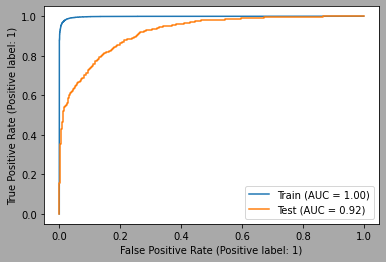

Test results: 
               precision    recall  f1-score   support

    trending       0.83      0.78      0.80      1068
non-trending       0.85      0.88      0.86      1486

    accuracy                           0.84      2554
   macro avg       0.84      0.83      0.83      2554
weighted avg       0.84      0.84      0.84      2554



In [22]:
print_stats(xgbclf, x_train_selected, y_train, x_test_selected, y_test)
y_pred = xgbclf.predict(x_test_selected)
print("Test results: \n", classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

z seleckcją 

Train accuracy: 0.980323054331865
Train precision: 0.9765897393325585
Train recall: 0.989902389767755
Train F1: 0.9832010029251985

Test accuracy: 0.8394675019577134
Test precision: 0.8484455958549223
Test recall: 0.8815612382234186
Test F1: 0.8646864686468647



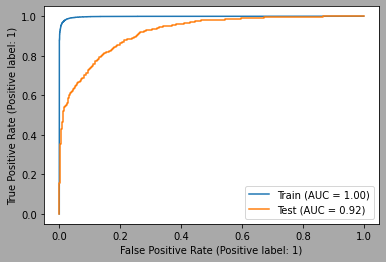

Test results: 
               precision    recall  f1-score   support

    trending       0.83      0.78      0.80      1068
non-trending       0.85      0.88      0.86      1486

    accuracy                           0.84      2554
   macro avg       0.84      0.83      0.83      2554
weighted avg       0.84      0.84      0.84      2554



In [23]:
print_stats(xgbclf, x_train_selected, y_train, x_test_selected, y_test)
y_pred = xgbclf.predict(x_test_selected)
print("Test results: \n", classification_report(y_test, y_pred, target_names=['trending', 'non-trending']))

Ważność atrybutów wg. weight pokazuje jak często w drzewach pojawiają się dane cechy

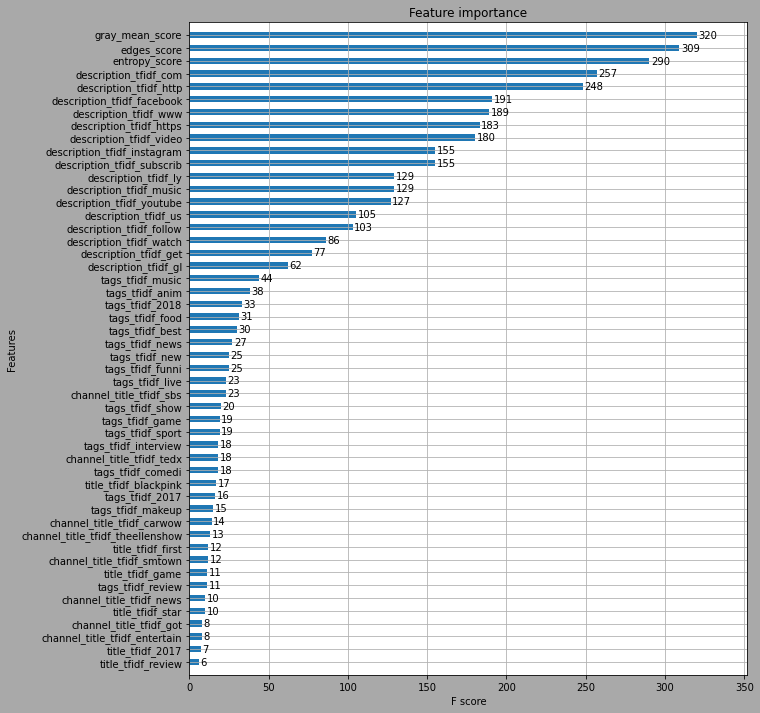

In [24]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='weight')
plt.show()

Ważność atrybutów wg. gain ozancza jak dużą część trafności wnosi dana cecha

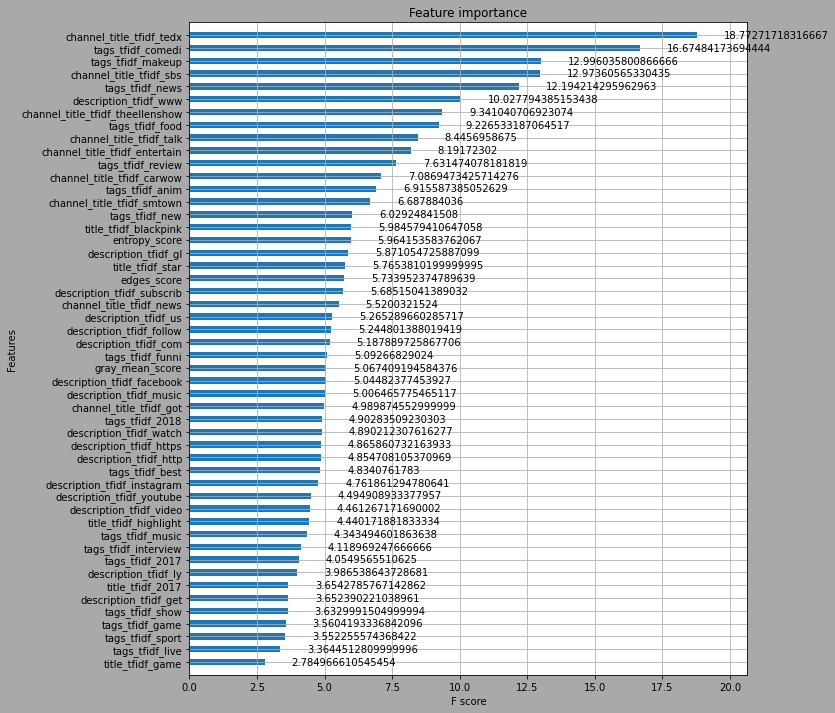

In [25]:
fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(xgbclf, max_num_features=50, height=0.5, ax=ax, importance_type='gain')
plt.show()

In [40]:
# xgb.plot_tree(xgbclf, num_trees=0)
# plt.rcParams['figure.figsize'] = [8, 6]
# plt.show()
plt.rcParams['figure.figsize'] = [8, 6]

### SHAP

Intercept -0.4007972212394919
Prediction_local [0.56570131]
Right: 0.6680653691291809


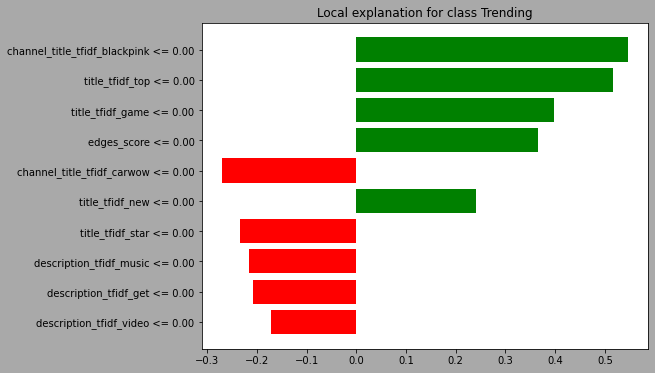

In [41]:
xgb_pred = lambda x: xgbclf.predict_proba(x).astype(float)

# LIME has one explainer for all models,

explainer = LimeTabularExplainer(
    x_train_selected.values,
    feature_names=x_train.columns.values.tolist(),
    training_labels=[0, 1],
    class_names=['Non trending', "Trending"],
    verbose=True)

j = 0

exp = explainer.explain_instance(x_test_selected.loc[[j]].values[0], xgb_pred)
exp.save_to_file("lime2.html")
# exp.show_in_notebook(show_table=True),
fig = exp.as_pyplot_figure()
plt.show(fig)

In [43]:
x_sampled = x_test_selected.sample(100, random_state=0)
explainerXgb = shap.TreeExplainer(xgbclf)
shap_values = explainerXgb.shap_values(x_sampled)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [58]:
shap.force_plot(explainerXgb.expected_value, shap_values[1], x_sampled.iloc[1])

In [61]:
shap_values = explainerXgb.shap_values(x_train_selected)
shap.force_plot(explainerXgb.expected_value, shap_values[1], x_train_selected.iloc[1])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(10215, 56)
(10215, 56)
()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


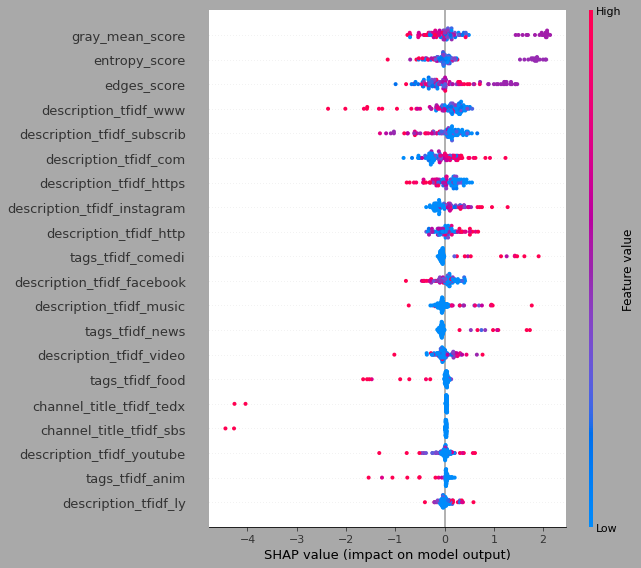

In [63]:
shap_values = explainerXgb.shap_values(x_sampled)
shap.summary_plot(shap_values, x_sampled)

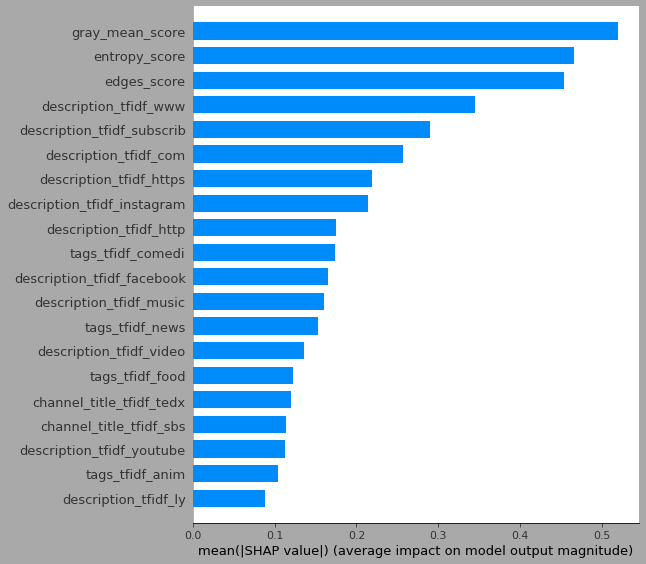

In [64]:
shap.summary_plot(shap_values, x_sampled, plot_type="bar")

### Testowanie drugiego klasyfikatora

### Interpretacja predykcji drugiego klasyfikatora

### Porównanie wyników klasyfikatorów

### Wiedza dla klienta

Profil charakterystycznych wartości atrybutów dla klasy trending

Co trzeba robić?

Czego się wystrzegać?